prediction is :  EA


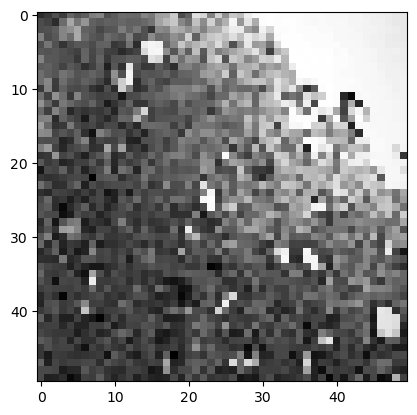

In [4]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pickle
import random
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

#dir='C:\\Users\\DELL\\Downloads\\btech project\\external_dataset'

#categories=['EA','EH','EP','NE(Follicular phase)','NE(Luteal phase)']

#data=[]

#for category in categories:
 #       path=os.path.join(dir,category)
  #      label=categories.index(category)
        
   #     for img in os.listdir(path):
            
    #        imgpath=os.path.join(path,img)
     #       pet_img=cv2.imread(imgpath,0)
      #      try:
                
       #         pet_img=cv2.resize(pet_img,(50,50))
        #        image=np.array(pet_img).flatten()
            
         #       data.append([image,label])
          #  except Exception as e:
           #     pass
            #cv2.imshow('image',pet_img)
            #break
       #break
#cv2.waitKey(0)
#cv2.destroyAllWindows()
#print(len(data))

#pick_in=open("data1.pickle",'wb')
#pickle.dump(data,pick_in)
#pick_in.close()

pick_in=open('data1.pickle','rb')
data=pickle.load(pick_in)
pick_in.close()

random.shuffle(data)
features=[]
labels=[]

for feature,label in data:
    features.append(feature)
    labels.append(label)
    
xtrain, xtest, ytrain,ytest=train_test_split(features,labels, test_size=0.75)

model=SVC(C=1,kernel='poly',gamma= 'auto')
model.fit(xtrain, ytrain)

#pick=open('model1.sav','wb')
#pickle.dump(model,pick)
#pick.close()

pick=open('model1.sav','rb')
model=pickle.load(pick)
pick.close()

prediction=model.predict(xtest)
accuracy=model.score(xtest,ytest)

categories=['EA','EH','EP','NE(Follicular phase)','NE(Luteal phase)']

#print('Accuracy: ',accuracy)
print('prediction is : ',categories[prediction[0]])

mypict=xtest[0].reshape(50,50)
plt.imshow(mypict,cmap='gray')
plt.show()

Prediction: NE(Luteal phase)


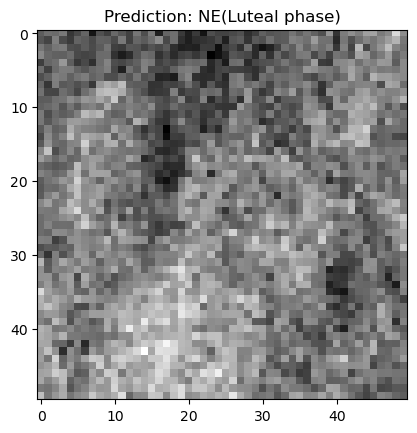

In [2]:
import warnings
warnings.filterwarnings('ignore')

import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pickle
import random
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Load data
with open('data1.pickle', 'rb') as pick_in:
    data = pickle.load(pick_in)

# Shuffle data
random.shuffle(data)

# Separate features and labels
features = [feature for feature, label in data]
labels = [label for feature, label in data]

# Split data into training and testing sets
xtrain, xtest, ytrain, ytest = train_test_split(features, labels, test_size=0.25, random_state=42)

# Normalize features
scaler = StandardScaler()
xtrain_scaled = scaler.fit_transform(xtrain)
xtest_scaled = scaler.transform(xtest)

# Apply PCA for dimensionality reduction
n_components = min(len(xtrain[0]), 50)  # Ensure n_components is not greater than the feature count
pca = PCA(n_components=n_components)
xtrain_pca = pca.fit_transform(xtrain_scaled)
xtest_pca = pca.transform(xtest_scaled)

# Hyperparameter tuning using Grid Search
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'gamma': ['scale', 'auto']
}
grid_search = GridSearchCV(SVC(), param_grid, cv=5, n_jobs=-1, verbose=0)
grid_search.fit(xtrain_pca, ytrain)

best_params = grid_search.best_params_

# Train the model with best parameters
model = SVC(**best_params)
model.fit(xtrain_pca, ytrain)

# Define category names
categories = ['EA', 'EH', 'EP', 'NE(Follicular phase)', 'NE(Luteal phase)']

# Visualize a prediction
prediction = model.predict([xtest_pca[0]])
print('Prediction:', categories[prediction[0]])

# Inverse PCA transformation to get the image back
reconstructed_img = pca.inverse_transform(xtest_pca[0])
reconstructed_img = reconstructed_img.reshape(50, 50)  # Ensure the shape is correct for your data

plt.imshow(reconstructed_img, cmap='gray')
plt.title(f'Prediction: {categories[prediction[0]]}')
plt.show()


Loading data...
Augmenting images...


Augmenting images: 200it [00:00, 613.37it/s]


Splitting data into training and testing sets...
Normalizing features...
Applying PCA...
Performing grid search for hyperparameter tuning...
Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best parameters: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Training the model with best parameters...
Cross-validating the model...
Cross-validated accuracy: 0.5640000000000001
Accuracy after tuning: 0.608


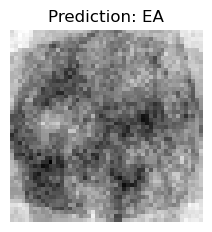

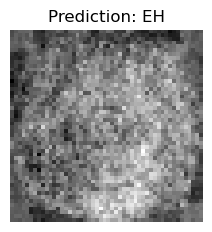

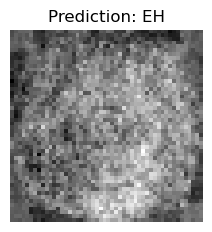

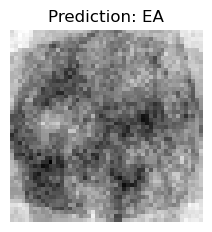

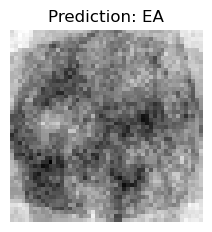

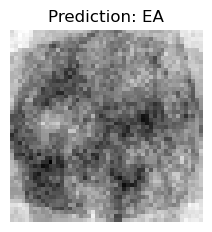

In [1]:
import warnings
warnings.filterwarnings('ignore')

import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pickle
import random
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from tkinter import Tk, filedialog, Label, Button
from PIL import Image, ImageTk
from PIL import UnidentifiedImageError  # Import UnidentifiedImageError
from tqdm import tqdm  # For progress bar
from scipy.spatial.distance import euclidean

# Initialize the GUI
root = Tk()
panelA = None
panelB = None

def augment_image(image):
    """ Perform basic data augmentation: rotations and flips """
    augmented_images = [image]
    
    # Rotate the image
    for angle in [15, -15]:
        M = cv2.getRotationMatrix2D((25, 25), angle, 1)
        rotated = cv2.warpAffine(image, M, (50, 50))
        augmented_images.append(rotated)
    
    # Flip the image horizontally
    flipped_h = cv2.flip(image, 1)
    augmented_images.append(flipped_h)

    return augmented_images

def preprocess_image(image_path, target_size=(50, 50)):
    """ Load and preprocess the image """
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        return None
    img_resized = cv2.resize(img, target_size)
    img_flattened = img_resized.flatten()
    return img_flattened

def histogram_similarity(image_path, reference_histograms):
    """ Check if the image histogram is similar to any of the reference histograms """
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        return False
    img_resized = cv2.resize(img, (50, 50))
    hist = cv2.calcHist([img_resized], [0], None, [256], [0, 256]).flatten()
    for ref_hist in reference_histograms:
        if euclidean(hist, ref_hist) < 1000:  # Threshold for similarity
            return True
    return False

def predict_image_category(image_path):
    img_flattened = preprocess_image(image_path)
    
    if img_flattened is None:
        return "Error: Unable to read the image. Please provide a valid image file.", None

    if not histogram_similarity(image_path, reference_histograms):
        return "Error: The provided image is not similar to the training images.", None

    img_scaled = scaler.transform([img_flattened])
    img_pca = pca.transform(img_scaled)
    prediction = model.predict(img_pca)
    category = categories[prediction[0]]

    reconstructed_img = pca.inverse_transform(img_pca[0])
    reconstructed_img = reconstructed_img.reshape(50, 50)  # Ensure the shape is correct for your data

    return category, reconstructed_img

def select_image():
    global panelA, panelB

    path = filedialog.askopenfilename()
    if len(path) > 0:
        category, reconstructed_img = predict_image_category(path)

        if reconstructed_img is None:
            label.config(text=category)
            return

        try:
            image = Image.open(path)
            image = image.resize((250, 250), Image.BICUBIC)
            image = ImageTk.PhotoImage(image)
        except UnidentifiedImageError:  # Handle UnidentifiedImageError
            label.config(text="Error: Please provide a correct image.")
            return

        # Display the input image in panelA
        if panelA is None:
            panelA = Label(image=image)
            panelA.image = image
            panelA.pack(side="left", padx=10, pady=10)
        else:
            panelA.configure(image=image)
            panelA.image = image

        # Display the prediction and explanation with the output image in panelB
        if panelB is None:
            panelB = Label(root)
            panelB.pack(side="right", padx=10, pady=10)

        # Provide information about the predicted category
        explanation = ""
        if category == 'EA':
            explanation = " Endomentrial adenocarcinoma is Most common type of endometrial cancer."
        elif category == 'EH':
            explanation = "Endometrial hyperplasia thickens the uterus lining and can lead to cancer if not managed."
        elif category == 'EP':
            explanation = " Endometrial Ployp is benign growth in the uterus, sometimes increasing cancer risk."
        elif category.startswith('NE'):
            explanation = " Non Endometrial cancer."

        label.config(text=f'Prediction: {category}\n\n{explanation}')

        # Display the output image in panelB
        fig = plt.figure(figsize=(2.5, 2.5))
        plt.imshow(reconstructed_img, cmap='gray')
        plt.title(f'Prediction: {category}')
        plt.axis('off')
        fig.canvas.draw()

        img = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
        img = img.reshape(fig.canvas.get_width_height()[::-1] + (3,))
        img = Image.fromarray(img)
        img = ImageTk.PhotoImage(img)

        if panelB is None:
            panelB = Label(image=img)
            panelB.image = img
            panelB.pack(side="right", padx=10, pady=10)
        else:
            panelB.configure(image=img)
            panelB.image = img

# Load data
print("Loading data...")
with open('data1.pickle', 'rb') as pick_in:
    data = pickle.load(pick_in)

# Shuffle data
random.shuffle(data)

# Separate features and labels
features = [feature for feature, label in data]
labels = [label for feature, label in data]

# Augment data
augmented_features = []
augmented_labels = []
print("Augmenting images...")
for feature, label in tqdm(zip(features, labels), desc="Augmenting images"):
    augmented_features.append(feature)
    augmented_labels.append(label)
    for aug_img in augment_image(feature.reshape(50, 50)):
        augmented_features.append(aug_img.flatten())
        augmented_labels.append(label)

# Split data into training and testing sets
print("Splitting data into training and testing sets...")
xtrain, xtest, ytrain, ytest = train_test_split(augmented_features, augmented_labels, test_size=0.25, random_state=42)

# Normalize features
print("Normalizing features...")
scaler = StandardScaler()
xtrain_scaled = scaler.fit_transform(xtrain)
xtest_scaled = scaler.transform(xtest)

# Apply PCA for dimensionality reduction
print("Applying PCA...")
n_components = min(len(xtrain[0]), 50)  # Ensure n_components is not greater than the feature count
pca = PCA(n_components=n_components)
xtrain_pca = pca.fit_transform(xtrain_scaled)
xtest_pca = pca.transform(xtest_scaled)

# Hyperparameter tuning using Grid Search
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}
print("Performing grid search for hyperparameter tuning...")
grid_search = GridSearchCV(SVC(), param_grid, cv=3, n_jobs=-1, verbose=1)
grid_search.fit(xtrain_pca, ytrain)

best_params = grid_search.best_params_
print(f"Best parameters: {best_params}")

# Train the model with best parameters
print("Training the model with best parameters...")
model = SVC(**best_params)
model.fit(xtrain_pca, ytrain)

# Cross-validate the model
print("Cross-validating the model...")
kfold = KFold(n_splits=3, shuffle=True, random_state=42)
cv_results = cross_val_score(model, xtrain_pca, ytrain, cv=kfold, scoring='accuracy')
print(f'Cross-validated accuracy: {cv_results.mean()}')

# Evaluate the model
accuracy = model.score(xtest_pca, ytest)
print('Accuracy after tuning:', accuracy)

# Define category names
categories = ['EA', 'EH', 'EP', 'NE(Follicular phase)', 'NE(Luteal phase)']

# Compute reference histograms for training data
reference_histograms = []
for feature in xtrain:
    img = feature.reshape(50, 50)
    hist = cv2.calcHist([img.astype(np.uint8)], [0], None, [256], [0, 256]).flatten()
    reference_histograms.append(hist)

# Button to select an image
btn = Button(root, text="Select an Image", command=select_image)
btn.pack(side="bottom", fill="both", expand="yes", padx=10, pady=10)

# Label to display prediction and explanation
label = Label(root, text="Prediction:")
label.pack(side="bottom", fill="both", expand="yes", padx=10, pady=10)

root.mainloop()
